In [2]:
import sys
sys.path.append("..")

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import math
import tensorflow as tf
import transforming_dynamics_model
import dynamics_model
import dynamics_subtractive_model

import tf_utils

In [115]:
from experiments.large import touch_ld_mu5_0_fixed as trainer
from utils_vpred import create_gif

In [116]:
tf.reset_default_graph()
conf = trainer.new_conf
model = transforming_dynamics_model.DynamicsModel(conf)

setting up network
OrderedDict([('default', True), ('experiment_name', 'touch'), ('transform', 'none'), ('data', 'touchldfixed'), ('data_dir', '/home/ashvin/lsdc/pushing_data/touch_ld'), ('sequence_length', 15), ('skip_frame', 1), ('context_frames', 2), ('use_state', 1), ('train_val_split', 1.0), ('batch_size', 32), ('learning_rate', 0.001), ('visualize', ''), ('file_visual', ''), ('discretize', 20), ('fsize', 32), ('masks', 0), ('run', 0), ('mu1', 0), ('mu2', 1e-06), ('mu3', 1), ('mu4', 0), ('mu5', 0), ('seq', 0), ('autoencoder', 'decode'), ('forwardloss', 'gaussian'), ('featactivation', 'none'), ('padding', 'valid'), ('loadalldata', 0), ('miningtemp', 0), ('initialize', 0), ('touch', 'Wclassify'), ('touchposweight', 13.3), ('discretizetouch', 20), ('ratiotouch', None)])
using frame sequence:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
using frame sequence:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
image features: (batch, featsize) (?, 32)
done with network setup


In [117]:
f = model.get_f(query=[model.image_batch] + model.touch_preds + model.action_losses + [model.touch_batch, model.inverse_loss_batch, model.raw_touch_batch, model.sample_batch, model.action_batch] + model.action_preds)

RESTORING FROM
/data2/shared/tf-lsdc/tf-data/tf_models/experiment_name_touch/transform_none/data_touchldfixed/skip_frame_1/fsize_32/mu2_1e-06/touch_Wclassify/touchposweight_13.3
Checkpoint found and restored: /data2/shared/tf-lsdc/tf-data/tf_models/experiment_name_touch/transform_none/data_touchldfixed/skip_frame_1/fsize_32/mu2_1e-06/touch_Wclassify/touchposweight_13.3/model-50000


In [118]:
result = model.run('test', batches=10, f=f)

In [119]:
values = result[0]

176


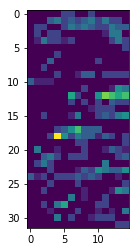

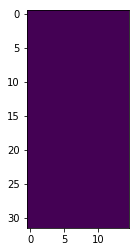

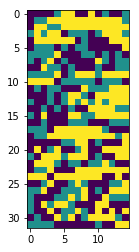

In [120]:
X = np.reshape(values[model.touch_batch][:, :, :, :], [32, 15, 20]).copy()
plt.figure()
plt.imshow(np.sum(X, 2))

S = values[model.sample_batch]
plt.figure()
plt.imshow(S)

Y = (np.sum(X, 2) > 0).astype(float)
p = int(np.sum(Y)) # num of examples with a touch
print p
n = p
inds = np.where(Y == 0)
N = len(inds[0])
c = np.random.randint(0, N, (n))
chosen_inds = [ind[c] for ind in inds]
Y[chosen_inds] = 0.5
plt.figure()
plt.imshow(Y)

In [121]:
values[model.action_preds[0]].shape

(32, 2, 20)

In [124]:
inverse_correct, inverse_wrong = 0, 0
tp, fp, tn, fn = 0, 0, 0, 0
p, n, x = 0, 0, 0
for b in range(10):
    values = result[b]
    for i in range(14):
        for j in range(32):
            T = np.reshape(values[model.touch_batch][j, i, :, :], [20, 1]).copy()
            S = values[model.sample_batch][j, i]
            t = values[model.touch_preds[i]][j] > 0
            A = values[model.action_batch][j, i, :, :]
            a = values[model.action_preds[i]][j, :, :]
            A_max = np.argmax(A, 1)
            a_max = np.argmax(a, 1)
            
            if S and np.any(T):
                p += 1
            elif S and not np.any(T):
                n += 1
            else:
                x += 1
            
            if True:
                tp += np.sum(np.logical_and(T == 1, t == 1))
                fp += np.sum(np.logical_and(T == 0, t == 1))
                tn += np.sum(np.logical_and(T == 0, t == 0))
                fn += np.sum(np.logical_and(T == 1, t == 0))


            if np.any(T):
                c = np.sum(A_max == a_max)
                inverse_correct += c
                inverse_wrong += (2 - c)
print p, n, x
print p + n + x

# touch accuracies
print tp, fp, tn, fn
S = float(tp + fp + tn + fn)
print tp/S, fp/S, tn/S, fn/S
print "T=1", (tp + fn)/S

print inverse_correct
print inverse_wrong
print 1.0 * inverse_correct / (inverse_correct + inverse_wrong)

1678 2802 0
4480
2184 45652 39419 2345
0.024375 0.509508928571 0.439944196429 0.026171875
T=1 0.050546875
647
2709
0.192789034565


In [125]:
ZZ = 0
inverse_correct, inverse_wrong = 0, 0
tp, fp, tn, fn = 0, 0, 0, 0
p, n, x = 0, 0, 0
for b in range(10):
    values = result[b]
    for i in range(14):
        for j in range(32):
            T = np.reshape(values[model.touch_batch][j, i, :, :], [20, 1]).copy()
            t = values[model.touch_preds[i]][j] > 0
            A = values[model.action_batch][j, i, :, :]
            a = values[model.action_preds[i]][j, :, :]
            A_max = np.argmax(A, 1)
            a_max = np.argmax(a, 1)
            
            if True:
                tp += np.sum(np.logical_and(T == 1, t == 1))
                fp += np.sum(np.logical_and(T == 0, t == 1))
                tn += np.sum(np.logical_and(T == 0, t == 0))
                fn += np.sum(np.logical_and(T == 1, t == 0))

            if np.any(T):
                ZZ += 1
                c = np.sum(A_max == a_max)
                inverse_correct += c
                inverse_wrong += (2 - c)
print p, n, x
print p + n + x

# touch accuracies
print tp, fp, tn, fn
S = float(tp + fp + tn + fn)
print tp/S, fp/S, tn/S, fn/S
print "T=1", (tp + fn)/S

print inverse_correct
print inverse_wrong
print 1.0 * inverse_correct / (inverse_correct + inverse_wrong)
print ZZ / (10 * 14 * 32.0)

0 0 0
0
2184 45652 39419 2345
0.024375 0.509508928571 0.439944196429 0.026171875
T=1 0.050546875
647
2709
0.192789034565
0.374553571429


In [126]:
def draw_action_pair(img1, img2, u_actual, u_pred):
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(img1)
    ax[1].imshow(img2)
#     ax[2].imshow(u_actual.T)
#     ax[3].imshow(u_pred.T)

In [127]:
def show_examples(TT, tt):
    NN = 0
    
    inverse_correct, inverse_wrong = 0, 0
    tp, fp, tn, fn = 0, 0, 0, 0
    p, n, x = 0, 0, 0
    for b in range(10):
        values = result[b]
        for i in range(14):
            for j in range(32):
                image_data = values[model.image_batch]
                T = np.reshape(values[model.touch_batch][j, i, :, :], [20, 1]).copy()
#                 S = values[model.sample_batch][j, i]
                t = values[model.touch_preds[i]][j] > 0
                A = values[model.action_batch][j, i, :, :]
                a = values[model.action_preds[i]][j, :, :]
                A_max = np.argmax(A, 1)
                a_max = np.argmax(a, 1)

#                 if S and np.any(T):
#                     p += 1
#                 elif S and not np.any(T):
#                     n += 1
#                 else:
#                     x += 1

#                 print T
#                 print S
                if True:
                    tp += np.sum(np.logical_and(T == 1, t == 1))
                    fp += np.sum(np.logical_and(T == 0, t == 1))
                    tn += np.sum(np.logical_and(T == 0, t == 0))
                    fn += np.sum(np.logical_and(T == 1, t == 0))
                    
                    if np.any(T == 1) == TT and np.any(t == 1) == tt:
                        img1 = image_data[j, i, :, :, :]
                        img2 = image_data[j, i+1, :, :, :]

                        u_actual = A
                        u_pred = a

                        draw_action_pair(img1, img2, u_actual, u_pred)
                        NN += 1
                        if NN > 50:
                            return
                    else:
                        print "skip"
                        
                if np.any(T):
                    c = np.sum(A_max == a_max)
                    inverse_correct += c
                    inverse_wrong += (2 - c)
#     print p, n, x
#     print p + n + x

#     # touch accuracies
#     print tp, fp, tn, fn
#     S = float(tp + fp + tn + fn)
#     print tp/S, fp/S, tn/S, fn/S
#     print "T=1", (tp + fn)/S

#     print inverse_correct
#     print inverse_wrong
#     print 1.0 * inverse_correct / (inverse_correct + inverse_wrong)

# True positives

skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip


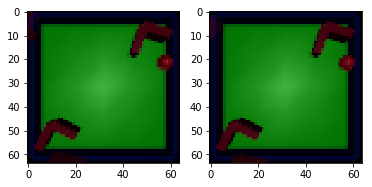

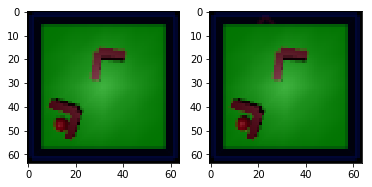

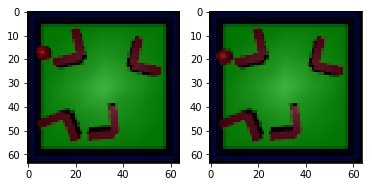

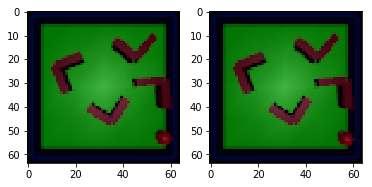

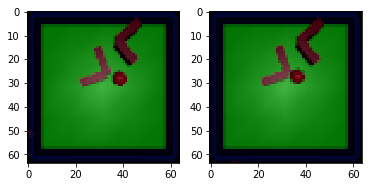

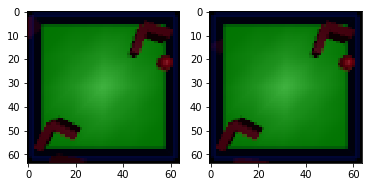

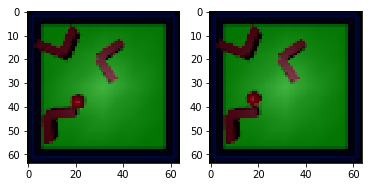

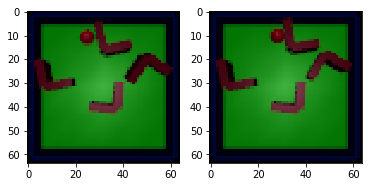

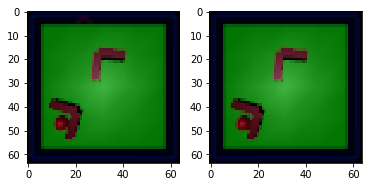

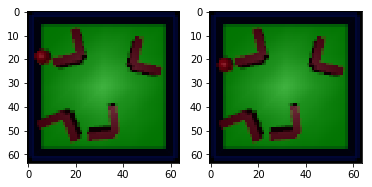

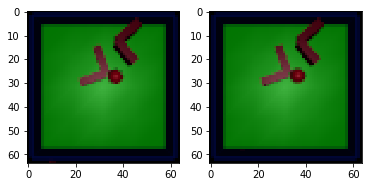

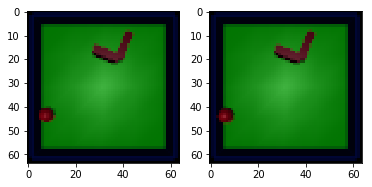

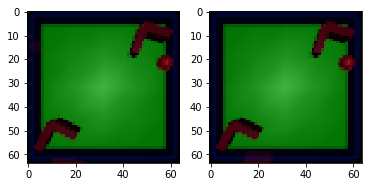

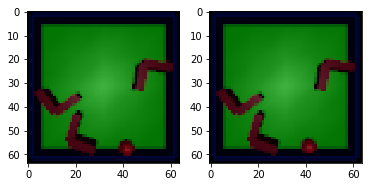

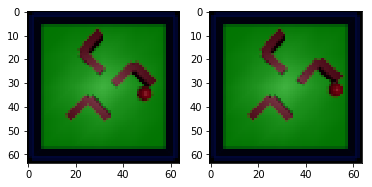

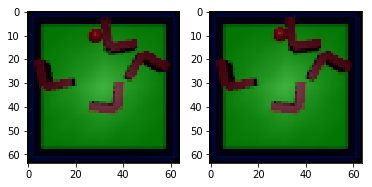

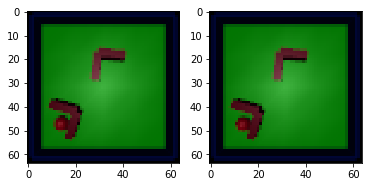

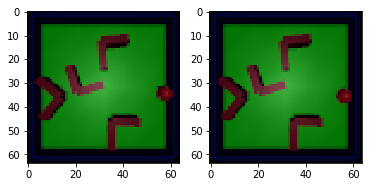

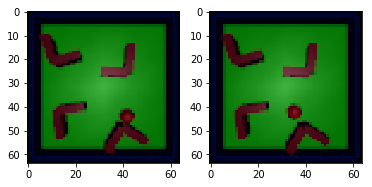

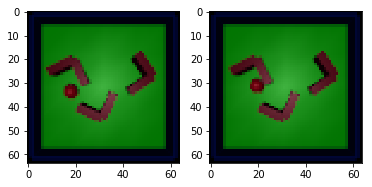

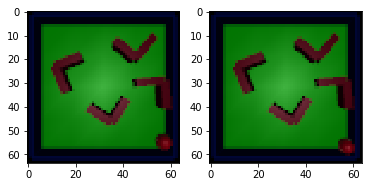

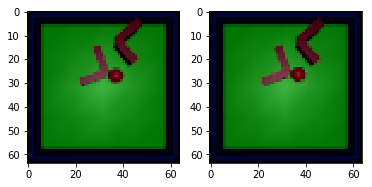

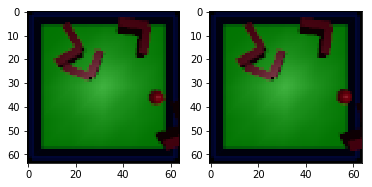

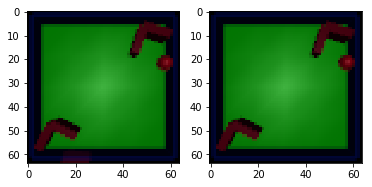

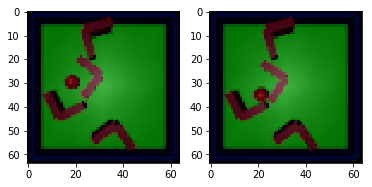

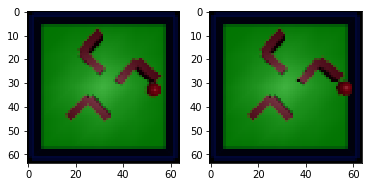

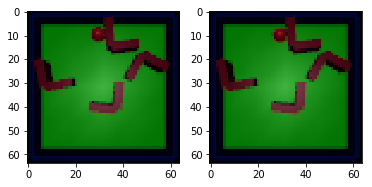

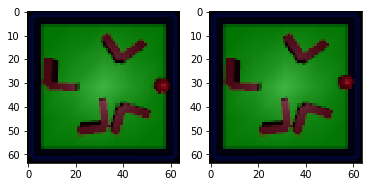

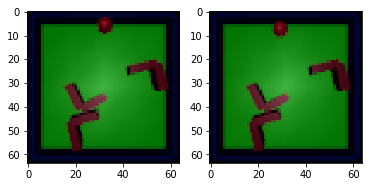

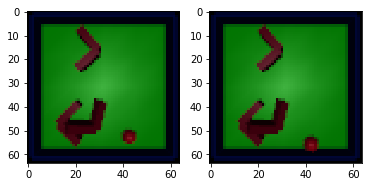

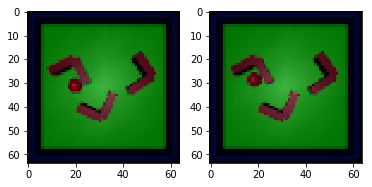

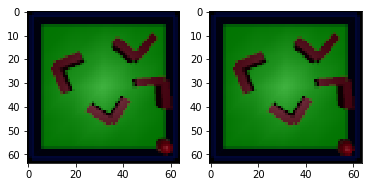

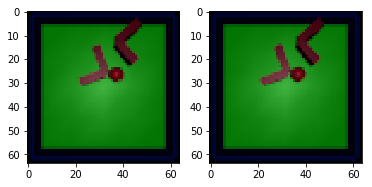

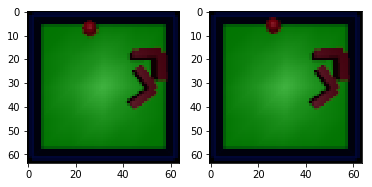

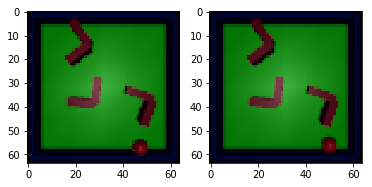

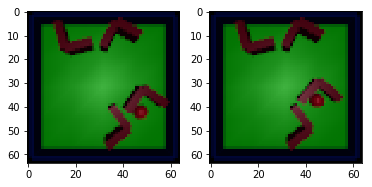

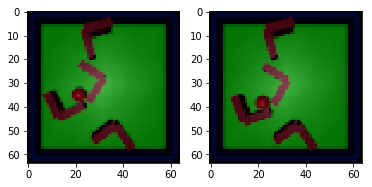

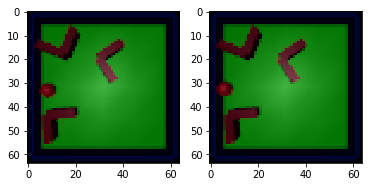

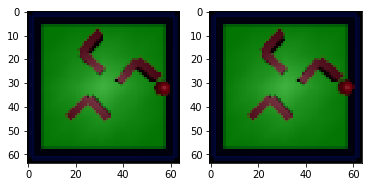

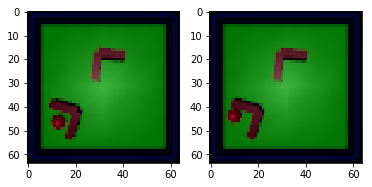

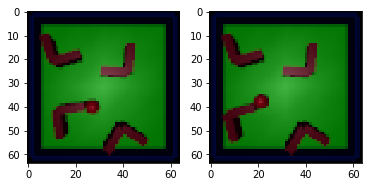

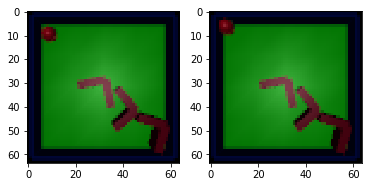

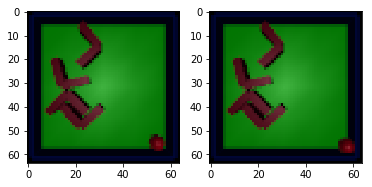

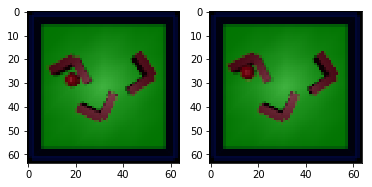

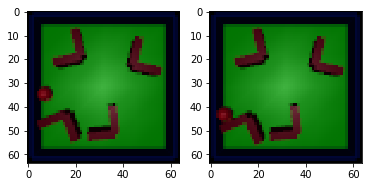

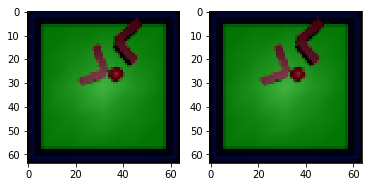

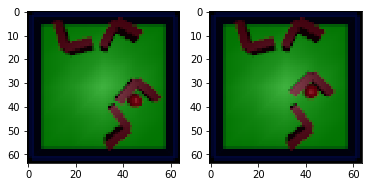

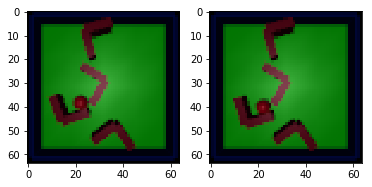

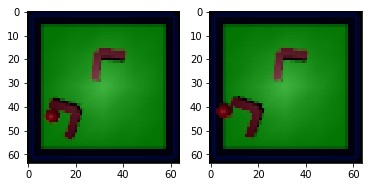

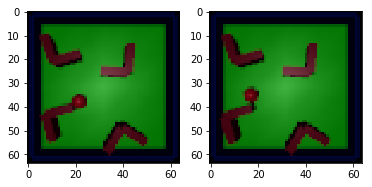

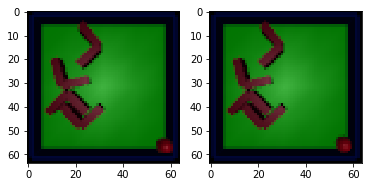

In [128]:
show_examples(1, 1)

# False positives

skip
skip
skip
skip
skip
skip
skip
skip
skip


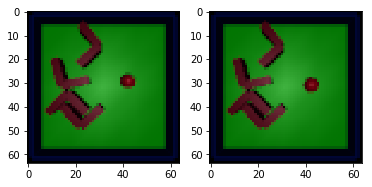

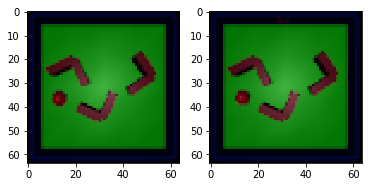

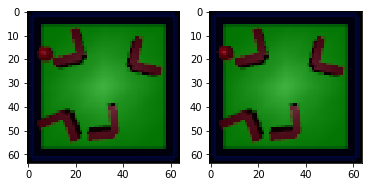

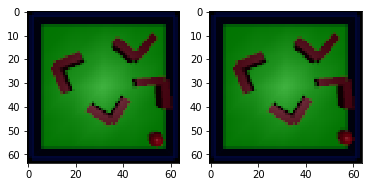

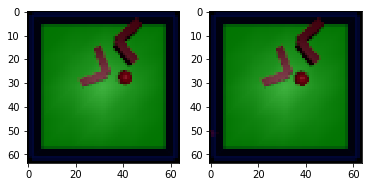

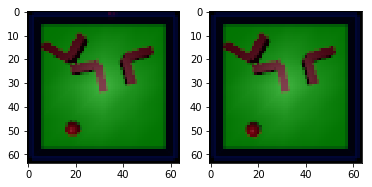

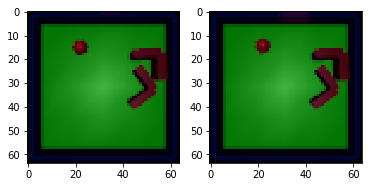

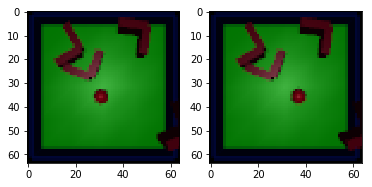

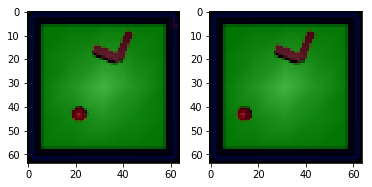

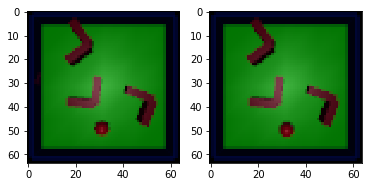

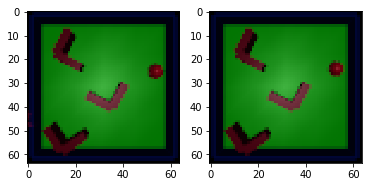

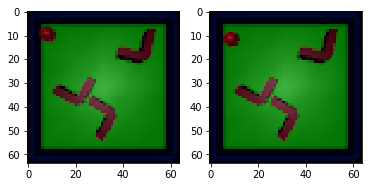

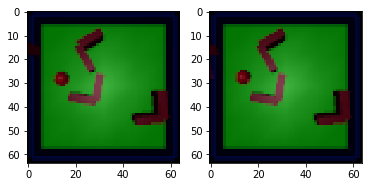

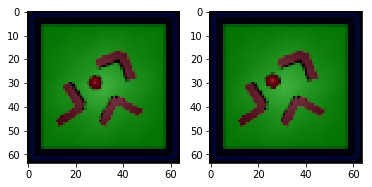

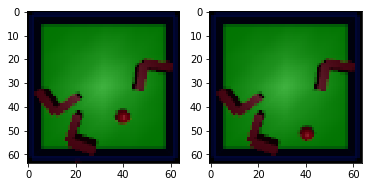

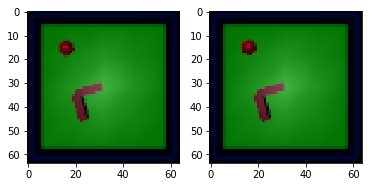

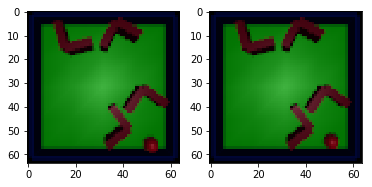

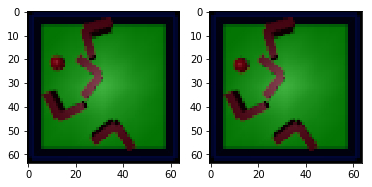

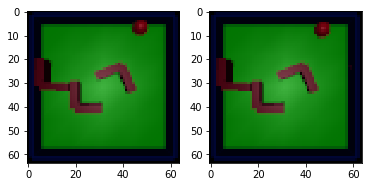

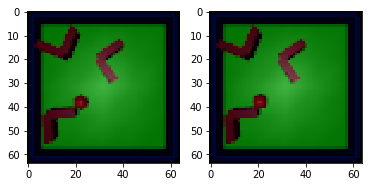

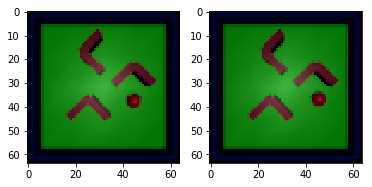

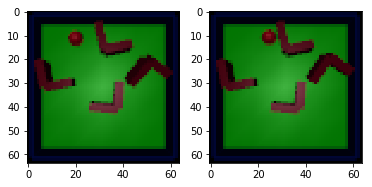

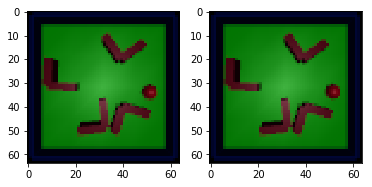

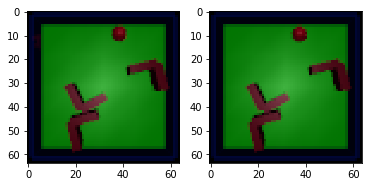

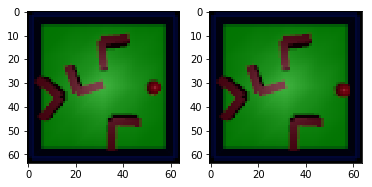

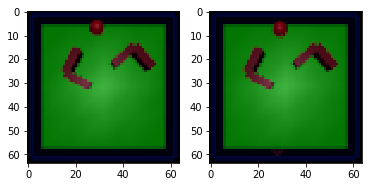

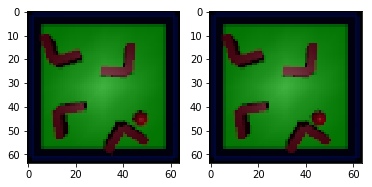

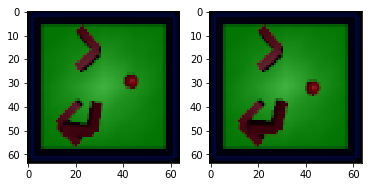

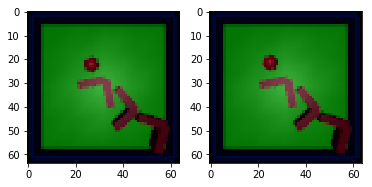

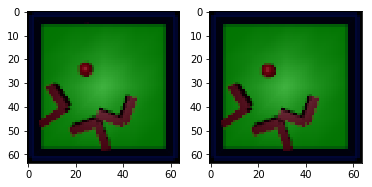

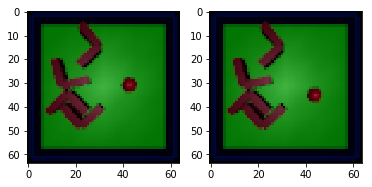

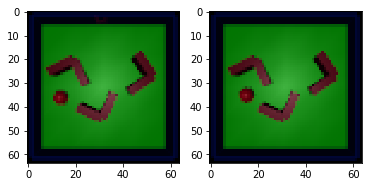

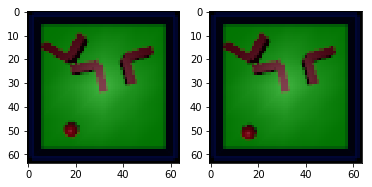

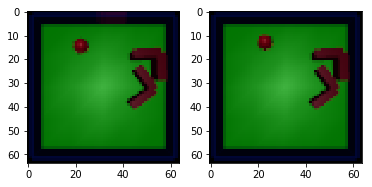

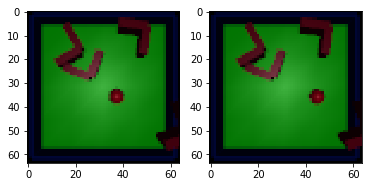

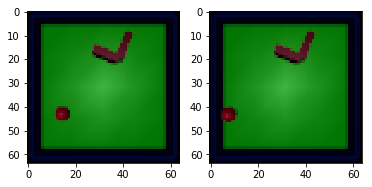

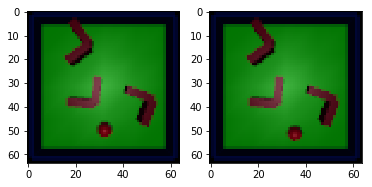

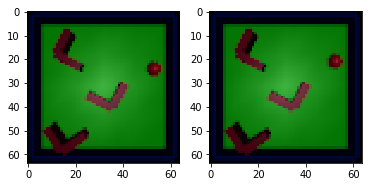

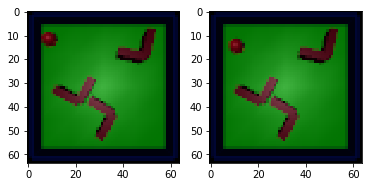

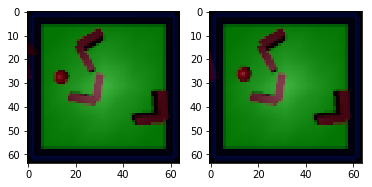

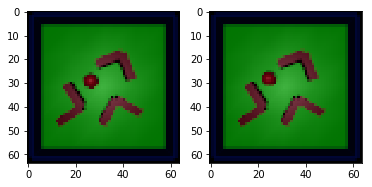

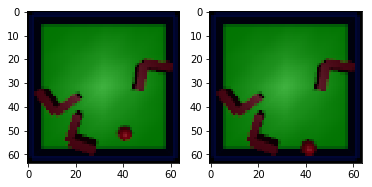

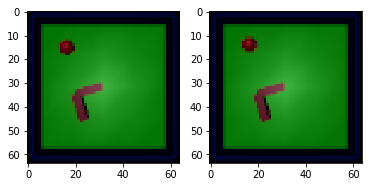

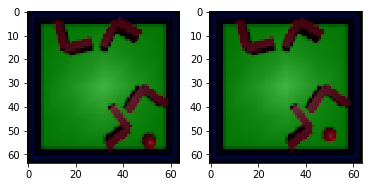

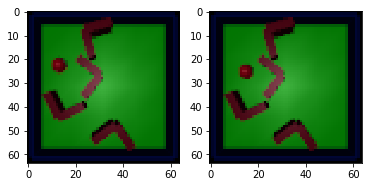

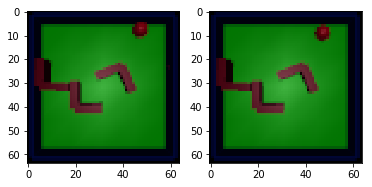

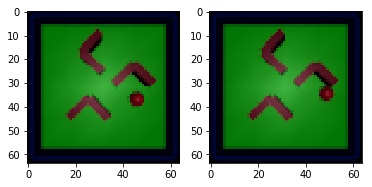

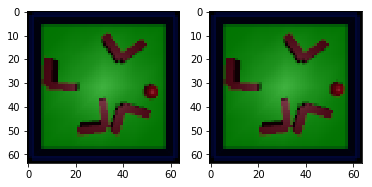

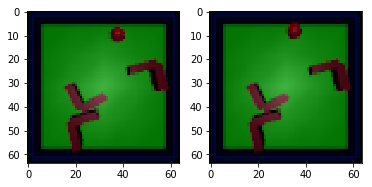

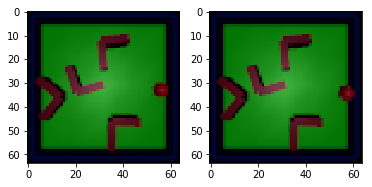

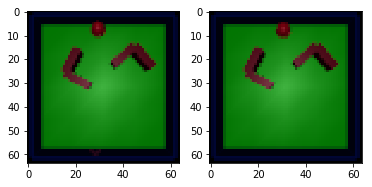

In [129]:
show_examples(0, 1)

# False negatives

In [130]:
show_examples(1, 0)

skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip


skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip


# True negatives (all)

In [132]:
def show_examples_all(TT, tt):
    NN = 0
    
    inverse_correct, inverse_wrong = 0, 0
    tp, fp, tn, fn = 0, 0, 0, 0
    p, n, x = 0, 0, 0
    for b in range(10):
        values = result[b]
        for i in range(14):
            for j in range(32):
                image_data = values[model.image_batch]
                T = np.reshape(values[model.touch_batch][j, i, :, :], [20, 1]).copy()
#                 S = values[model.sample_batch][j, i]
                t = values[model.touch_preds[i]][j] > 0
                A = values[model.action_batch][j, i, :, :]
                a = values[model.action_preds[i]][j, :, :]
                A_max = np.argmax(A, 1)
                a_max = np.argmax(a, 1)

#                 if S and np.any(T):
#                     p += 1
#                 elif S and not np.any(T):
#                     n += 1
#                 else:
#                     x += 1

                if True:
                    tp += np.sum(np.logical_and(T == 1, t == 1))
                    fp += np.sum(np.logical_and(T == 0, t == 1))
                    tn += np.sum(np.logical_and(T == 0, t == 0))
                    fn += np.sum(np.logical_and(T == 1, t == 0))
                    
                    if np.all(np.logical_and(T == TT, t == tt)):
                        img1 = image_data[j, i, :, :, :]
                        img2 = image_data[j, i+1, :, :, :]

                        u_actual = A
                        u_pred = a

                        draw_action_pair(img1, img2, u_actual, u_pred)
                        NN += 1
                        if NN > 50:
                            return
                        
                if np.any(T):
                    c = np.sum(A_max == a_max)
                    inverse_correct += c
                    inverse_wrong += (2 - c)
show_examples_all(0, 0)

In [22]:
def showable(img):
    image_data

In [23]:
np.min(image_data)

0.0

0.617822
4.90196e-07
(64, 64, 3)


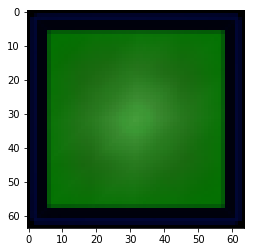

In [11]:
img_mean = np.load('/home/ashvin/lsdc/pushing_data/finer_temporal_resolution_substep10/train/mean.npy')
plt.imshow(img_mean)
img_mean.dtype
print np.max(img_mean)
print np.min(img_mean)
print img_mean.shape

In [41]:
print model.raw_touch_batch.get_shape()

(?, 15, 20)


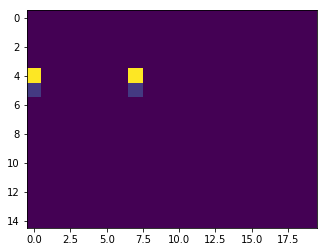

In [80]:
plt.imshow(values[model.raw_touch_batch][1, :, :])

In [22]:
values = result[0]

(20, 1)
(20,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
(20, 1)
(20,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
(20, 1)
(20,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
(20, 1)
(20,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
(20, 1)
(20,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
(20, 1)
(20,)
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.]
[  

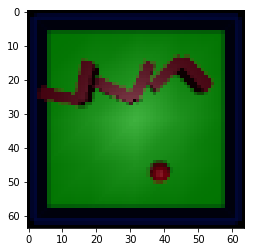

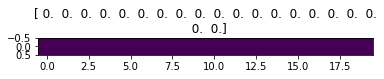

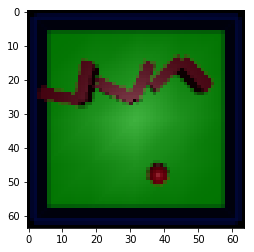

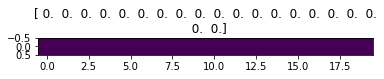

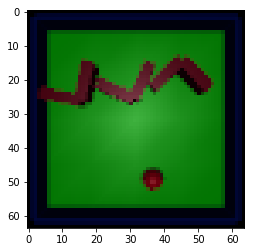

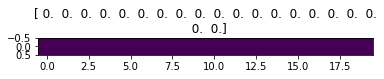

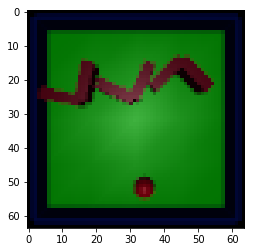

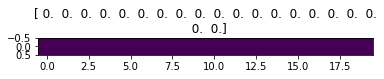

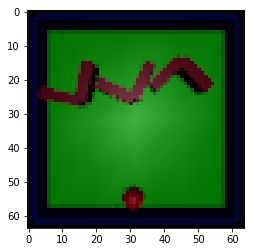

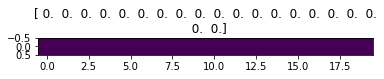

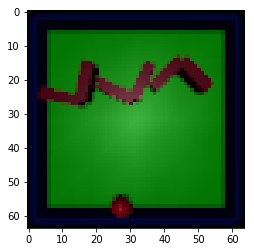

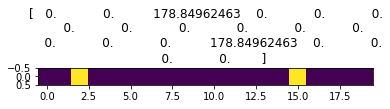

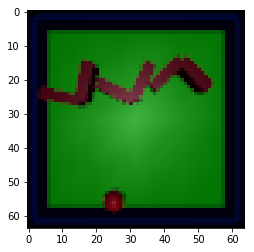

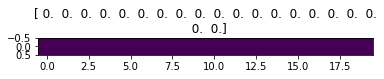

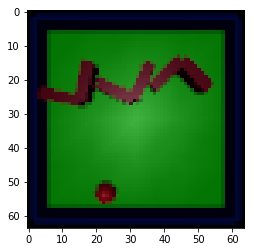

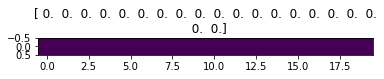

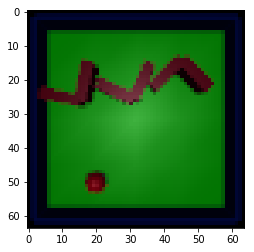

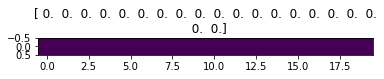

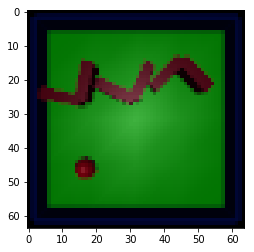

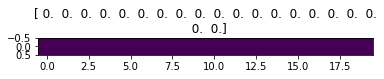

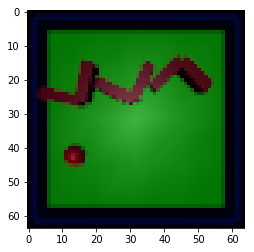

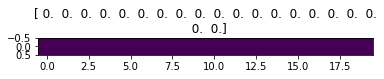

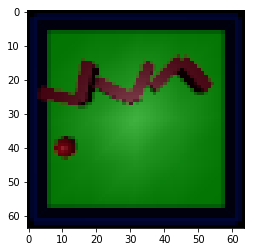

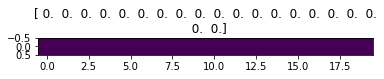

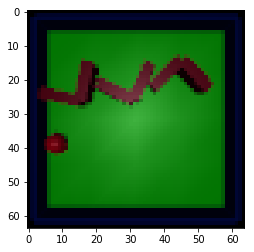

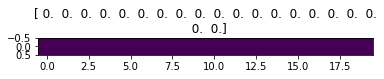

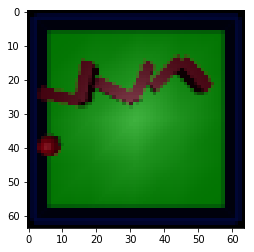

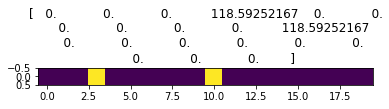

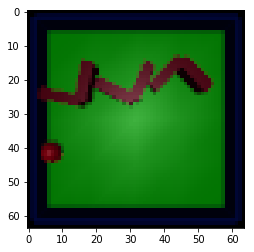

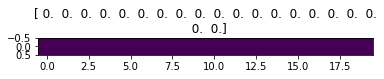

In [24]:
n = 5
for i in range(15):
    plt.figure()
#     f, ax = plt.subplots(1, 2)
    plt.imshow(image_data[n, i, :, :, :])
    plt.figure()
    
    j = i
    T = values[model.touch_batch][n, j, :, :]
    Traw = values[model.raw_touch_batch][n, j, :]
    plt.imshow(Traw.flatten()[:, None].T)
    print T.shape
    print Traw.shape
    print T.flatten()
    print Traw.flatten()
    plt.title(Traw.flatten())
#     a = result[b][model.action_losses[i]]
#     for j in range(32):
#         if np.all(0 == T[:, :]):
#             no_touch_loss.append(a[j])
#         else:
#             touch_loss.append(a[j])